In [50]:
import cv2
import numpy as np
from skimage.feature import match_template
import matplotlib.pyplot as plt
from copy import deepcopy
from imutils.object_detection import non_max_suppression # pip install imutils
from PIL import Image


In [76]:
def generate_sections(reference_image,multi_up_image, output_img_path,threshold=0.75,saveit=False):

    reference_gray = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
    multi_up_gray = cv2.cvtColor(multi_up_image, cv2.COLOR_BGR2RGB)
    mask = np.zeros(reference_image.shape[:2], dtype=np.uint8)
    mask[659:2370,166:2000] = 255
    result = cv2.matchTemplate(multi_up_gray, reference_gray, cv2.TM_CCOEFF_NORMED, None)
    print(f"{result.shape} total results found...")

    # threshold = 0.75  # Adjust this threshold as needed
    loc = np.where(result >= threshold)

    # Perform non-maximum suppression.
    # template_h, template_w = reference_gray.shape[:2]
    # rects = []
    # for (x, y) in zip(loc[0], loc[1]):
    #     rects.append((x, y, x + template_w, y + template_h))
    # pick = non_max_suppression(np.array(rects))

    # Define a function to remove duplicates within a specified distance (tolerance)
    def remove_duplicates(points, tolerance, horizontal_tolerance):
        unique_points = []
        unique_indices = []
        for i, (x, y) in enumerate(points):
            is_unique = True
            for j, (x_other, y_other) in enumerate(unique_points):
                if abs(x - x_other) < horizontal_tolerance:
                    is_unique = False
                    break
                distance = np.sqrt((x - x_other) ** 2 + (y - y_other) ** 2)
                if distance <= tolerance:
                    is_unique = False
                    break
            if is_unique:
                unique_points.append((x, y))
                unique_indices.append(i)
        
        return np.array(unique_points), np.array(unique_indices)

    x, y = loc
    print(f"{len(x)} total occurrences found...")

    tolerance = 10  # Adjust this value as needed
    horizontal_tolerance = reference_image.shape[0]//2
    unique_loc, unique_indices = remove_duplicates(np.column_stack((x, y)), tolerance, horizontal_tolerance)
    print(f"{len(unique_indices)} unique found...")

    matched_sections = []
    bb = deepcopy(multi_up_image)
    for pt in unique_loc:
        tl=(0,pt[0])
        br=(multi_up_image.shape[1], pt[0] + reference_image.shape[0])
        bb = cv2.rectangle(bb, tl, br, (0, 0, 255), 3)
        matched_sections.append(multi_up_image[tl[1]:br[1],tl[0]:br[0]] )

    if (saveit):
        for i, matched_img in enumerate(matched_sections):
            # if matched_img.size != 0:
            cv2.imwrite(f"{output_img_path}/{i}.jpg", matched_img)

    return result, bb, matched_sections, loc, unique_loc

In [79]:
template_image_path = 'Final_test\Reference_samples\YE-A094-3_Print scan_page-r.jpg'

In [89]:
ref = '67'
reference_image = cv2.imread(f'./A0{ref}/SA-A0{ref}.jpg', cv2.IMREAD_COLOR)
multi_up_image = cv2.imread("multi_up.bmp", cv2.IMREAD_COLOR) #f'./A0{ref}/A0{ref}_0.bmp'
reference_image = cv2.resize(reference_image, (830, 1073))

r,b,m,l,u = generate_sections(reference_image, multi_up_image, f'./A0{ref}',threshold=0.8,saveit=False)

(5399, 1798) total results found...
54719 total occurrences found...
1 unique found...


In [68]:
# crop out white padding
image = cv2.imread(template_image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(max_contour)
image = image[y:y+h, x:x+w]
cv2.imwrite(template_image_path, image)

True

In [47]:
reference_image.shape

(1073, 830, 3)

In [46]:
m[1].shape

(1073, 2482, 3)

In [43]:
[(u_[0],0,multi_up_image.shape[1],reference_image.shape[0]) for u_ in u]

[(1099, 0, 2482, 1073), (4367, 0, 2482, 1073)]

In [33]:
# cv2.imshow("bb",cv2.resize(b, None, fx=0.15, fy=0.15))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

(-0.5, 2481.5, 6527.5, -0.5)

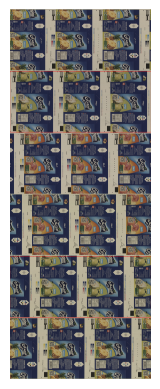

In [36]:
# change bgr2rgb

plt.imshow(cv2.cvtColor(b, cv2.COLOR_BGR2RGB))
plt.axis('off')
# plt.imshow(b)